<a href="https://colab.research.google.com/github/henrykohl/DeepLearningByPytorchTutorial/blob/master/extras/exercises/09_pytorch_model_deployment_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="red">09. PyTorch Model Deployment Exercises</font>

Welcome to the 09. PyTorch Model Deployment exercises.

Your objective is to write code to satisify each of the exercises below.

Some starter code has been provided to make sure you have all the resources you need.

> **Note:** There may be more than one solution to each of the exercises.

## Resources

1. These exercises/solutions are based on [section 09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/jOX5ZCkWO-0) (but try the exercises yourself first!).
3. See [all solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

> **Note:** The first section of this notebook is dedicated to getting various helper functions and datasets used for the exercises. The exercises start at the heading "Exercise 1: ...".

### Get various imports and helper functions

The code in the following cells prepares imports and data for the exercises below. They are taken from [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/).

torch version: 1.12.1+cu113

torchvision version: 0.13.1+cu113

In [ ]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [ ]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    # !git clone https://github.com/mrdbourke/pytorch-deep-learning
    # !mv pytorch-deep-learning/going_modular .
    # !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    # !rm -rf pytorch-deep-learning
    !git clone https://github.com/henrykohl/DeepLearningByPytorchTutorial
    !mv DeepLearningByPytorchTutorial/going_modular .
    !mv DeepLearningByPytorchTutorial/helper_functions.py . # get the helper_functions.py script
    !rm -rf DeepLearningByPytorchTutorial
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'DeepLearningByPytorchTutorial'...
remote: Enumerating objects: 942, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 942 (delta 40), reused 0 (delta 0), pack-reused 852
Receiving objects: 100% (942/942), 143.86 MiB | 17.02 MiB/s, done.
Resolving deltas: 100% (556/556), done.
Updating files: 100% (48/48), done.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Get data

Want to download the data we've been using in PyTorch Model Deployment: https://www.learnpytorch.io/09_pytorch_model_deployment/#1-getting-data

In [ ]:
# Download pizza, steak, sushi images from GitHub
# image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
#                            destination="pizza_steak_sushi")
# image_path

image_path = download_data(source="https://github.com/henrykohl/DeepLearningByPytorchTutorial/raw/master/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/henrykohl/DeepLearningByPytorchTutorial/raw/master/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi')

In [ ]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

### Preprocess data

Turn images into tensors using same code as PyTorch Paper Replicating section 2.1 and 2.2: https://www.learnpytorch.io/08_pytorch_paper_replicating/#21-prepare-transforms-for-images

In [ ]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [ ]:
# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f6e5784fe20>,
 ['pizza', 'steak', 'sushi'])

In [ ]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

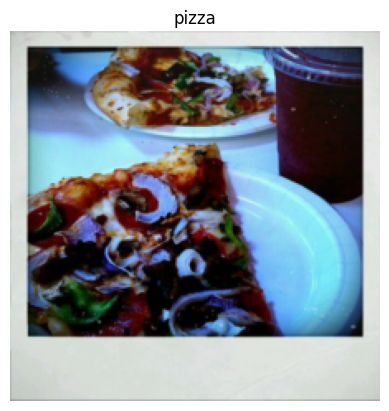

In [ ]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## Exercise 1. Make and time predictions with both feature extractor models on the test dataset using the GPU (`device="cuda"`).

* Compare the model's prediction times on GPU vs CPU - does this close the gap between them? As in, does making predictions on the GPU make the ViT feature extractor prediction times closer to the EffNetB2 feature extractor prediction times?
* You'll find code to do these steps in [section 5. Making predictions with our trained models and timing them](https://www.learnpytorch.io/09_pytorch_model_deployment/#5-making-predictions-with-our-trained-models-and-timing-them) and [section 6. Comparing model results, prediction times and size](https://www.learnpytorch.io/09_pytorch_model_deployment/#6-comparing-model-results-prediction-times-and-size).

In [ ]:
# TODO: your code

### <font color="purple">Train two models on Pizza, Steak, Sushi data

<font color="purple">Need:
* <font color="purple">Trained EffNetB2 feature extractor
* <font color="purple">Trained ViT feature extractor

### <font color="purple">EffNetB2

<font color="purple">See function creation source here: https://www.learnpytorch.io/09_pytorch_model_deployment/#31-creating-a-function-to-make-an-effnetb2-feature-extractor

In [ ]:
def create_effnetb2_model(num_classes:int=3,
              seed:int=42):
  """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
      num_classes (int, optional): number of classes in the classifier head.
          Defaults to 3.
      seed (int, optional): random seed value. Defaults to 42.

    Returns:
      model (torch.nn.Module): EffNetB2 feature extractor model.
      transforms (torchvision.transforms): EffNetB2 image transforms.
  """
  # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.efficientnet_b2(weights=weights)

  # 4. Freeze all layers in base model
  for param in model.parameters():
    param.requires_grad = False


  # 5. Change classifier head with random seed for reproducibility
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3,inplace=True),
      nn.Linear(in_features=1408,out_features=num_classes)
  )

  return model, transforms

In [ ]:
effnetb2, effnetb2_transforms = create_effnetb2_model()
# effnetb2
effnetb2_transforms

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 122MB/s]


ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [ ]:
# Create dataloaders for EffNetB2
from going_modular.going_modular import data_setup

BATCH_SIZE = 32
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                      test_dir=test_dir,
                                                      transform=effnetb2_transforms,
                                                      batch_size=BATCH_SIZE)

len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

In [ ]:
# Train EffNetB2 feature extractor
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=effnetb2.parameters(),lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()
# loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                  train_dataloader=train_dataloader_effnetb2,
                  test_dataloader=test_dataloader_effnetb2,
                  epochs=10,
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  device=device)

In [ ]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

### <font color="purple">Preparing and training ViT feature extractor

In [ ]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
  """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
      num_classes (int, optional): number of target classes. Defaults to 3.
      seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
      model (torch.nn.Module): ViT-B/16 feature extractor model.
      transforms (torchvision.transforms): ViT-B/16 image transforms.
  """
  # Create ViT_B_16 pretrained weights, transforms and model
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # Freeze all layers in model
  for param in model.parameters():
    param.requires_grad = False

  # Change classifier head to suit our needs (this will be trainable)
  torch.manual_seed(seed)
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3,inplace=True),
      nn.Linear(in_features=768,      # keep this the same as original model
            out_features=num_classes) # update to reflect target number of classes
  )

  return model, transforms


In [ ]:
vit, vit_transforms = create_vit_model()
# vit
vit_transforms

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 172MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
# Create dataloaders for ViT
from going_modular.going_modular import data_setup

BATCH_SIZE = 32
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                 test_dir=test_dir,
                                                 transform=vit_transforms ,
                                                 batch_size=BATCH_SIZE)



len(train_dataloader_vit), len(test_dataloader_vit), class_names

In [ ]:
# Train ViT feature extractor
from going_modular.going_modular import engine

optimizer = torch.optim.Adam(params=vit.parameters(),lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
vit_results = engine.train(model=vit,
                train_dataloader=train_dataloader_vit,
                test_dataloader=test_dataloader_vit,
                epochs=10,
                optimizer=optimizer,
                loss_fn=loss_fn,
                device=device)

In [ ]:
plot_loss_curves(vit_results)

### <font color="purple">Get all the images from the test path

<font color="purple">Want to make predictions acrosss the test dataset images and time them on GPU to see if they're faster on GPU or CPU...

In [ ]:
test_dir

PosixPath('data/pizza_steak_sushi/test')

In [ ]:
from pathlib import Path
test_image_paths = list(test_dir.glob("*/*.jpg")) # list(Path(test_dir).glob("*/*.jpg"))寫法有點多餘，test_dir就是PosixPath
len(test_image_paths)

150

In [ ]:
test_image_paths[:5]

[PosixPath('data/pizza_steak_sushi/test/pizza/724290.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/441659.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2582289.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/796922.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/129666.jpg')]

### <font color="purple">Get function for making predictions and timing them

<font color="purple">See the source here: https://www.learnpytorch.io/09_pytorch_model_deployment/#51-creating-a-function-to-make-predictions-across-the-test-dataset

In [ ]:
class_names

['pizza', 'steak', 'sushi']

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
           model: torch.nn.Module,
           transform: torchvision.transforms,
           class_names: List[str],
           device: str = "cuda" if torch.cuda.is_available() else "cpu"       ) -> List[Dict] :

  # 2. Create an empty list to store prediction dictionaires
  pred_list = []

  # 3. Loop through target paths
  for path in tqdm(paths):

    # 4. Create empty dictionary to store prediction information for each sample
    pred_dict = {}

    # 5. Get the sample path and ground truth class name
    pred_dict["image_path"] = path
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # 6. Start the prediction timer
    start_time = timer()

    # 7. Open image path
    img = Image.open(path)

    # 8. Transform the image, add batch dimension and put image on target device
    transformed_image = transform(img).unsqueeze(0).to(device)

    # 9. Prepare model for inference by sending it to target device and turning on eval() mode
    model.to(device) # model = model.to(device)
    model.eval()

    # 10. Get prediction probability, predicition label and prediction class
    with torch.inference_mode():
      """perform inference on target sample"""
      pred_logit = model(transformed_image)
      """turn logits into prediction probabilities"""
      pred_prob = torch.softmax(pred_logit,dim=1)
      """turn prediction probabilities into prediction label"""
      pred_label = torch.argmax(pred_prob,dim=1)
      """hardcode prediction class to be on CPU"""
      pred_class = class_names[pred_label.cpu()]
      """注意-pred_label是一個scalar tensor, 所以class_names中的pred_label可以不用加上.item()"""

      # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
      pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(),4)
      """.unsqueeze(0)與.cpu()不需要"""
      pred_dict["pred_class"] = pred_class

    # 12. End the timer and calculate time per pred
    end_time = timer()
    pred_dict["time_for_pred"] = round(end_time-start_time, 4)

    # 13. Does the pred match the true label?
    pred_dict["correct"] = pred_class == class_name

    # 14. Add the dictionary to the list of preds
    pred_list.append(pred_dict)

  # 15. Return list of prediction dictionaries
  return pred_list


In [ ]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### <font color="purple">Make and time predictions on CPU

In [ ]:
# Make and time predictions on CPU
effnetb2_preds_on_cpu = pred_and_store(paths=test_image_paths,
                      model=effnetb2,
                      transform=effnetb2_transforms,
                      class_names=class_names,
                      device="cpu")

In [ ]:
# Make and time predictions on CPU
vit_preds_on_cpu = pred_and_store(paths=test_image_paths,
                   model=vit,
                   transform=vit_transforms,
                   class_names=class_names,
                   device="cpu")

### <font color="purple">Make and time predictions on GPU

In [ ]:
effnetb2_preds_on_gpu = pred_and_store(paths=test_image_paths,
                      model=effnetb2,
                      transform=effnetb2_transforms,
                      class_names=class_names,
                      device="cuda")

vit_preds_on_gpu = pred_and_store(paths=test_image_paths,
                   model=vit,
                   transform=vit_transforms,
                   class_names=class_names,
                   device="cuda")

### <font color="purple">Comparing prediction times on CPU and GPU

In [ ]:
# input 是 predictions 結果
import pandas as pd

def get_mean_pred_time(input):
  df = pd.DataFrame(input)
  return df.time_for_pred.mean()

effnetb2_cpu_pred_time = get_mean_pred_time(effnetb2_preds_on_cpu)
effnetb2_cpu_pred_time

In [ ]:
effnetb2_gpu_pred_time = get_mean_pred_time(effnetb2_preds_on_gpu)
vit_cpu_pred_time = get_mean_pred_time(vit_preds_on_cpu)
vit_gpu_pred_time = get_mean_pred_time(vit_preds_on_gpu)

pred_times = {"effnetb2_cpu": effnetb2_cpu_pred_time,
        "vit_cpu": vit_cpu_pred_time,
        "effnetb2_gpu": effnetb2_gpu_pred_time,
        "vit_gpu": vit_gpu_pred_time}

pred_times_df = pd.DataFrame(pred_times, index=[0])
pred_times_df

<font color="purple">It looks like the predictions on the GPU are much faster than the CPU overall.

<font color="purple">And it looks like the ViT model is faster than EffNetB2 on the GPU as well.

<font color="purple">So potentially if we had access to a GPU in deployment, a ViT model would be better due to having lower latency (prediction time) as well as better performance.

<font color="purple">But if we're focused on deploying to CPU, EffNetB2 wins because of good performance + faster inference time.

## Exercise 2. The ViT feature extractor seems to have more learning capacity (due to more parameters) than EffNetB2, how does it go on the larger 20% split of the entire Food101 dataset?

* Train a ViT feature extractor on the 20% Food101 dataset for 5 epochs, just like we did with EffNetB2 in section [10. Creating FoodVision Big](https://www.learnpytorch.io/09_pytorch_model_deployment/#10-creating-foodvision-big).

<font color="purple">Want to download and split whole Food101 dataset into 20% dataset.

<font color="purple">E.g. instead of training on all ~100,000 images in Food101, only train and test on ~20,000 (to save time experimenting).

In [ ]:
# TODO: your code

### <font color="purple">Create ViT feature extractor for Food101

<font color="purple">Need to get a ViT model capable of fitting on Food101 data (freeze the base layers and update the output layers to work with 101 classes).

In [ ]:
# Create another ViT feature model instance
vit_food101_20_percent, vit_transforms = create_vit_model(num_classes=101)

# Print ViT model summary (uncomment for full output)
from torchinfo import summary
summary(vit_food101_20_percent,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            78,437               Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### <font color="purple">Create Food101 data transforms

<font color="purple">Because of the large amount of data, going to use data augmentation to (hopefully) prevent overfitting.

<font color="purple">See here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#81-how-to-deal-with-overfitting

In [ ]:
# Create Food101 training data transforms (only perform data augmentation on the training images)

food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms,
])

food101_train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [ ]:
from torchvision import datasets


# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                 split="train", # dataset split to get
                 transform=food101_train_transforms, # perform data augmentation on training data
                 download=True) # want to download?


# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                 split="test",
                 transform=food101_train_transforms, # perform data augmentation on test data
                 download=True) # want to download?



100%|██████████| 4996278331/4996278331 [04:08<00:00, 20140221.57it/s]


Extracting data/food-101.tar.gz to data


In [ ]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]


['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
len(train_data)

75750

### <font color="purple">Create Food101 20% data splits

<font color="purple">Want to split whole Food101 dataset into:
* <font color="purple">Train set: 20% of whole original Food101 train dataset
* <font color="purple">Test set: 20% of whole original Food101 test dataset

In [ ]:
def split_dataset(dataset:torchvision.datasets, split_size:float=0.2, seed:int=42):
  """Randomly splits a given dataset into two proportions based on split_size and seed.

    Args:
      dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
      split_size (float, optional): How much of the dataset should be split?
          E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.
      seed (int, optional): Seed for random generator. Defaults to 42.

    Returns:
      tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
          random_split_2 is of size (1-split_size)*len(dataset).
  """
  # Create split lengths based on original dataset length
  length_1 = int(len(dataset)*split_size) # desired length
  length_2 = len(dataset) - length_1 # remaining length

  # Print out info
  print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")


  # Create splits with given random seed
  random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
                                     lengths=[length_1,length_2],
                                     generator= torch.manual_seed(seed))

  return random_split_1, random_split_2

In [ ]:
# Create training 20% split of Food101
train_data_food101_20_percent, _ = split_dataset(dataset=train_data, split_size=0.2)

# Create testing 20% split of Food101
test_data_food101_20_percent, _ = split_dataset(dataset=test_data, split_size=0.2)


len(train_data_food101_20_percent), len(test_data_food101_20_percent)

[INFO] Splitting dataset of length 75750 into splits of size: 15150 (20%), 60600 (80%)
[INFO] Splitting dataset of length 25250 into splits of size: 5050 (20%), 20200 (80%)


(15150, 5050)

### <font color="purple">Create DataLoaders for Food101 20 percent data

In [ ]:
# Turn torch Datasets into DataLoaders
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = 2
train_dataloader_food101 = DataLoader(dataset=train_data_food101_20_percent,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=NUM_WORKERS)



test_dataloader_food101 = DataLoader(dataset=test_data_food101_20_percent,
                     batch_size=BATCH_SIZE,
                     shuffle=True,
                     num_workers=NUM_WORKERS)




len(train_dataloader_food101), len(test_dataloader_food101)

(474, 158)

### <font color="purple">Train ViT feature extractor on 20% of Food101 data

<font color="purple">**Note:** The cell below may take 15 mins to run on Google Colab (due to ~15,000 training images and ~5000 testing images).

In [ ]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer
optimizer = torch.optim.Adam(params=vit_food101_20_percent,
                lr=1e-3)

# Train the model
set_seeds()
vit_food101_20_percent_results = engine.train(model=vit_food101_20_percent,
                          train_dataloader=train_dataloader_food101,
                          test_dataloader=test_dataloader_food101,
                          epochs=5,
                          optimizer=optimizer,
                          loss_fn=loss_fn,
                          device=device)

## Exercise 3. Make predictions across the 20% Food101 test dataset with the ViT feature extractor from exercise 2 and find the "most wrong" predictions
* The predictions will be the ones with the highest prediction probability but with the wrong predicted label.
* Write a sentence or two about why you think the model got these predictions wrong.

In [ ]:
# TODO: your code

In [ ]:
# Loop through test DataLoader (with batch size 1)
# Make prediction with model
# Store prediction and prediction probability to dictionary
# Append dictionary to list
# Inspect list

# Easy way: set up batch size of 1 of test data loader - from Sali1997s
# Create batch size of 1 (predict on 1 image at a time)
test_dataloader_food101_batch_size_1 = DataLoader(test_data_food101_20_percent,
                            batch_size=1,
                            shuffle=False,
                            num_workers=NUM_WORKERS)

# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()


# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_pred_list = []
for X, y in tqdm(test_dataloader_food101_batch_size_1):
  # Send data to target device
  X, y= X.to(device), y.to(device)

  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {}

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X),dim=1)
    """pred_probs大小與vit_food101_20_percent(X)相同的tensor, 內容為tensor([[p1,p2,p3,... ]]) """
    pred_labels = torch.argmax(pred_probs, dim=1)
    """pred_labels 維度=1 的scalar tensor, 內容為tensor([i]), i是整數, pi=max(p1,p2,,p3,...)"""
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    """
    torch.max(pred_probs) 維度=0 的scalar tensor, 內容為tensor(p)
    .numpy()把tensor轉成array, 結果為array(p, dtype=float32)

    """
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    """.numpy()把tensor轉成array, 結果為array(i)。[0]把array中的第一個值取出 """
    pred_dict["label"] = y.cpu().numpy()[0]
    """
    y大小與pred_labels相同的tensor, 內容為tensor([x]), x是整數
    .numpy()把tensor轉成array, 結果為array(x)。[0]把array中的第一個值取出

    """

  vit_food101_pred_list.append(pred_dict)

  0%|          | 0/5050 [00:00<?, ?it/s]

[928] 0.3965


In [ ]:
food101_class_names[:5]

In [ ]:
# Create DataFrame with various columns
pred_df_20_percent = pd.DataFrame(vit_food101_pred_list)

# Create a column for if the prediction is correct
pred_df_20_percent["is_correct"] = pred_df_20_percent["pred_label"] == pred_df_20_percent["label"]

# Create class name columns (e.g. pred_label=72 -> pred_class="pancakes")
pred_df_20_percent["pred_class"] = pred_df_20_percent["pred_label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent["label_class"] = pred_df_20_percent["label"].apply(lambda x: food101_class_names[x])
pred_df_20_percent.head()

```python
# 改用 .assign()
pred_df_20_percent = (pred_df_20_percent
  .assign(
    pred_class = lambda df: df["pred_label"].map(lambda d: food101_class_names[d]),
    label_class = lambda df: df["label"].map(lambda d: food101_class_names[d])
  )
)
```



In [36]:
# Get top 10 samples that are "most wrong", e.g. highest pred_prob but wrong prediction - why??
pred_df_20_percent[pred_df_20_percent["is_correct"] == False].sort_values("pred_prob", ascending=False)[:10]

<font color="red">Comparing the "pred_class" to the "label_class" the model is often wrong on samples that are visually similar.

<font color="red">For example, gyoza and dumplings look quite the same.

<font color="red">The same as paella and fried rice.

<font color="red">And onion rings and fried calamari.

<font color="red">The model is getting confused on similar looking classes and thus predictions are in the right "space" but not necessarily correct compared to the ground truth.

## Exercise 4. Evaluate the ViT feature extractor across the whole Food101 test dataset rather than just the 20% version, how does it perform?
* Does it beat the original Food101 paper's best result of 56.4% accuracy?

In [ ]:
# TODO: your code

In [ ]:
# Check length of Food101 test data
len(test_data)

In [ ]:
# Turn Food101 test data into DataLoader
# Easy way: set up batch size of 1 of test data loader - from Sali1997s
# Create batch size of 1 (predict on 1 image at a time)
test_dataloader_food101_all_data_batch_size_1 = DataLoader(test_data,
                                 batch_size=1,
                                 shuffle=False,
                                 num_workers=NUM_WORKERS)

len(test_dataloader_food101_all_data_batch_size_1)

In [ ]:
# Prepare model (do this outside the loop)
vit_food101_20_percent = vit_food101_20_percent.to(device)
vit_food101_20_percent.eval()

# Loop through test DataLoader with batch size 1 and make predictions on each image
# store predictions and truth values to a dictionary and then append dictionary to list for inspection later
vit_food101_all_test_data_pred_list = []
for X, y in tqdm(test_dataloader_food101_all_data_batch_size_1):
  # Send data to target device
  X, y = X.to(device), y.to(device)

  # Create empty prediction dictionary (each sample gets a dictionary)
  pred_dict = {}

  # Make predictions
  with torch.inference_mode():
    pred_probs = torch.softmax(vit_food101_20_percent(X), dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)
    pred_dict["pred_prob"] = torch.max(pred_probs).cpu().numpy()
    pred_dict["pred_label"] = pred_labels.cpu().numpy()[0]
    pred_dict["label"] = y.cpu().numpy()[0]

  vit_food101_all_test_data_pred_list.append(pred_dict)

In [ ]:
# Evalaute model on entire test set
food101_all_test_data_df = pd.DataFrame(vit_food101_all_test_data_pred_list)
food101_all_test_data_df["is_correct"] = food101_all_test_data_df["pred_label"] == food101_all_test_data_df["label"]
food101_all_test_data_df.is_correct.value_counts()

In [ ]:
# Calculate accuracy across Food101 all test
print(f"Accuracy of ViT model on all of Food101 test data: {food101_all_test_data_df.is_correct.value_counts()[1] / len(food101_all_test_data_df)}")

## Exercise 5. Head to [Paperswithcode.com](https://paperswithcode.com/) and find the current best performing model on the Food101 dataset.
* What model architecture does it use?

In [ ]:
# TODO: your answer to the above

<font color="purple">These results are valid as of 26 August 2022:
* <font color="purple">Looks like EffNetL2 with extra training data performs the best on Food101 - https://paperswithcode.com/paper/sharpness-aware-minimization-for-efficiently-1 (96.18% accuracy)
* <font color="purple">But Bamboo also looks like it performs the best on another benchmark - https://paperswithcode.com/paper/bamboo-building-mega-scale-vision-dataset

## Exercise 6. Write down 1-3 potential failure points of our deployed FoodVision models and what some potential solutions might be.
* For example, what happens if someone was to upload a photo that wasn't of food to our FoodVision Mini model?

In [ ]:
# TODO: your answer to the above

## Exercise 7. Pick any dataset from [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) and train a feature extractor model on it using a model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) (you could use one of the model's we've already created, e.g. EffNetB2 or ViT) for 5 epochs and then deploy your model as a Gradio app to Hugging Face Spaces.
* You may want to pick smaller dataset/make a smaller split of it so training doesn't take too long.
* I'd love to see your deployed models! So be sure to share them in Discord or on the [course GitHub Discussions page](https://github.com/mrdbourke/pytorch-deep-learning/discussions).

In [ ]:
# TODO: your code